# Importing libraries

In [72]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from esm import pretrained
import torch
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, TimeDistributed, Bidirectional, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#!pip install fair-esm

# Data reading

In [3]:
import pandas as pd

# Loading the file without headers
data_train_X = pd.read_csv("readable_datasets/amino_acids_train.txt", header=None)

# Printing the first few rows
print(data_train_X.head())

                                                   0
0  F D Y Q T V Y F A N Q Y G L R T I E L G E S E ...
1  R P E S E L I R Q S W R V V S R S P L E H G T ...
2  M K I A I L G A G C Y R T H A A A G I T N F M ...
3  R R T V P R G T L R K I I K K H K P H L R L A ...
4  Q V E I S X A E W D V X N I I W D K K S V S A ...


In [4]:
data_train_y = pd.read_csv("readable_datasets/pss_train.txt", header=None)
data_test_X = pd.read_csv("readable_datasets/amino_acids_test.txt", header=None)
data_test_y = pd.read_csv("readable_datasets/pss_test.txt", header=None)

# Data preprocessing

In [5]:
#converting to list
amino_acids_train = data_train_X.iloc[:, 0].tolist()
amino_acid_test = data_test_X.iloc[:, 0].tolist()
print("Extracted sequence successfully.")

Extracted sequence successfully.


In [6]:
# coverting to list
pss_train = data_train_y.iloc[:, 0].tolist()
pss_test = data_test_y.iloc[:, 0].tolist()
print("Extracted sequence successfully.")

Extracted sequence successfully.


In [7]:
# Loading the latest ESM model and batch converter
esm_model, alphabet = pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to C:\Users\anjal/.cache\torch\hub\checkpoints\esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to C:\Users\anjal/.cache\torch\hub\checkpoints\esm2_t6_8M_UR50D-contact-regression.pt


In [8]:
# defining the function to check white spaces
def check_whitespace(sequences):
    for seq in sequences:
        if ' ' in seq or '\t' in seq:
            print(f"Whitespace found in sequence: '{seq}'")

In [9]:
# defining function to remove white spaces
def clean_sequences(sequences):
    cleaned_sequences = []
    for seq in sequences:
        cleaned_seq = re.sub(r'\s+', '', seq).upper()  # Remove whitespace and convert to uppercase
        cleaned_sequences.append(cleaned_seq)
    return cleaned_sequences

In [12]:
amino_acids_train_cleaned = clean_sequences(amino_acids_train)

In [13]:
amino_acid_test_cleaned = clean_sequences(amino_acid_test)

In [14]:
# Checking for whitespace in the PSS labels
print("Checking for whitespace in training PSS labels:")
check_whitespace(pss_train)

Checking for whitespace in training PSS labels:
Whitespace found in sequence: 'L L L L E E E L S L S E E E E E E E L S L L S S S L L H H H H T T E E E E E E E E E S S S S L L S L E E E E E E E L G G G G T T L E E T T T L L B L E E L L G G G E E E S L S E E E E L T T L S E E E E E E E E L H H H H H S G G G G S S L E E E E E E E E E E E S S S E E L L L E E S S S S L L T T L G G G E E E L L L S E E E E E E E E E L T T L E E E E E E E E E E E E E T T E E E E E E E L L S S G G G S E E E E E E E S S S S E E E E E E E E E L T T S L E E E E E E E E E E L T T S E E E E E E L S T T L E E E E E E E E E E E E E T T L G G G S L E E E E E E E E E E E E T T T T E E E E E E E E E E E E E L L L L S E E E L L E E L L'
Whitespace found in sequence: 'L L S H H H H H H H H H H H H T S H H H H H H H H H H H H H H H L G G G G G G L L B T T B L L S S H H H H T T L H H H H H H H H H H H H H H H H H H H T S S L S S S S H H H H H H H H H H H H H H T L L T T H H H H H H H H H H H H H H H H H G G G S L H H H H H H

In [15]:
print("Checking for whitespace in test PSS labels:")
check_whitespace(pss_test)

Checking for whitespace in test PSS labels:
Whitespace found in sequence: 'L L L H H H H H H H H H H H H H H H H H H H H T T T T T E E E E E E E E L L S S S S L E E E E E T T S H H H H H T B L L B L L G G G L'
Whitespace found in sequence: 'L E E E E E L L T T T S L L H H H H H H H H H H H H T T L L E E E E E S L S B T T B L L H H H H H H H H H H H T L S L S S S L L S L E E E L T T S L E E E S H H H H H H H T L'
Whitespace found in sequence: 'L L L L L L L L L L S L L S L T T S T T T T L L L S S L L H H H H H H H L L L S L L S E E E E E E E T T L L H H H H H H H H H H H H L T T L L L T T G G G L L E E E E E E L L E E L T T T L S E E S S L L H H H H H H H H H H S L L L L T T L B S B L T T L L B L L L H H H H H H H T T L E E E E E E E E E T T S H H H H T T T L L B S L T T L L S H H H H H H H L G G G L T T T T L S L L H H H H H H H H L L S E E E E E L G G G G G L B B S S G G G B T S B H H H H H H H H T L E E E L S H H H H H H L L L L B T T B L E E E E L L S S S L L L S E E L L L L E E T H

In [16]:
# Cleaning the target labels
pss_train_cleaned = clean_sequences(pss_train)
pss_test_cleaned = clean_sequences(pss_test)

In [18]:
# Verifying unique secondary structure classes before encoding
unique_pss_labels_train = set("".join(pss_train_cleaned))
unique_pss_labels_test = set("".join(pss_test_cleaned))
print("Unique labels in training data (pss_train) before encoding:", unique_pss_labels_train)
print("Unique labels in test data (pss_test) before encoding:", unique_pss_labels_test)

Unique labels in training data (pss_train) before encoding: {'E', 'S', 'B', 'H', 'T', 'L', 'I', 'G'}
Unique labels in test data (pss_test) before encoding: {'E', 'S', 'B', 'H', 'T', 'L', 'I', 'G'}


In [21]:
# Label envoding of target labels
label_encoder = LabelEncoder()
label_encoder.fit(list(unique_pss_labels_train | unique_pss_labels_test))  # Fit on combined unique labels from both sets

LabelEncoder()

In [22]:

pss_train_encoded = [label_encoder.transform(list(seq)) for seq in pss_train_cleaned]
pss_test_encoded = [label_encoder.transform(list(seq)) for seq in pss_test_cleaned]

In [23]:
# Verifying unique classes after encoding
print("Unique encoded labels in training data:", np.unique(np.concatenate(pss_train_encoded)))
print("Unique encoded labels in test data:", np.unique(np.concatenate(pss_test_encoded)))

Unique encoded labels in training data: [0 1 2 3 4 5 6 7]
Unique encoded labels in test data: [0 1 2 3 4 5 6 7]


In [24]:
# defining the function for generating ESM embeddings
def get_esm_embeddings(sequences):
    embeddings = []
    for seq in sequences:
        batch_labels, batch_strs, batch_tokens = batch_converter([("seq1", seq)])
        with torch.no_grad():
            results = esm_model(batch_tokens, repr_layers=[6])  #  layer 6
        token_embeddings = results["representations"][6][0, 1:len(seq) + 1].mean(0).numpy()  # Excluding special tokens
        embeddings.append(token_embeddings)
    return np.vstack(embeddings)

In [25]:
# extracting the embeddings for training and test sets
esm_embeddings_train = get_esm_embeddings(amino_acids_train_cleaned)
esm_embeddings_test = get_esm_embeddings(amino_acid_test_cleaned)

In [26]:
# Saving the embeddings as .npy files
np.save("esm_embeddings_train.npy", esm_embeddings_train)
np.save("esm_embeddings_test.npy", esm_embeddings_test)

In [27]:
# Checking the shape of the embeddings
print("Shape of ESM embeddings (train):", esm_embeddings_train.shape)
print("Shape of ESM embeddings (test):", esm_embeddings_test.shape)

Shape of ESM embeddings (train): (5534, 320)
Shape of ESM embeddings (test): (514, 320)


In [28]:
# padding the data for LSTM model
max_sequence_length = esm_embeddings_train.shape[1]
X_train = pad_sequences(esm_embeddings_train, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(esm_embeddings_test, maxlen=max_sequence_length, padding='post')

In [30]:
# making the data uniform
pss_train_encoded_padded = pad_sequences(pss_train_encoded, padding='post')
pss_test_encoded_padded = pad_sequences(pss_test_encoded, padding='post')

In [31]:
# converting the encoded labels  to one-hot labels
y_train = to_categorical(pss_train_encoded_padded)
y_test = to_categorical(pss_test_encoded_padded)

In [32]:
# verifying the shape of target variable
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5534, 696, 8)
y_test shape: (514, 700, 8)


In [33]:
# Printinmg the shape of the training and test data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5534, 320)
Shape of y_train: (5534, 696, 8)
Shape of X_test: (514, 320)
Shape of y_test: (514, 700, 8)


In [35]:
# equence length based on X_train and X_test
desired_length = X_train.shape[1]  # 320
# Padding y_train and y_test to match X_train and X_test sequence length
pss_train_encoded_padded = pad_sequences(pss_train_encoded, maxlen=desired_length, padding='post', truncating='post')
pss_test_encoded_padded = pad_sequences(pss_test_encoded, maxlen=desired_length, padding='post', truncating='post')

In [36]:
# Converting to one-hot encoding
y_train = to_categorical(pss_train_encoded_padded, num_classes=8)
y_test = to_categorical(pss_test_encoded_padded, num_classes=8)

In [37]:
# Check the new shapes to confirm they match
print("Shape of X_train:", X_train.shape)  # Should be (5534, 320)
print("Updated shape of y_train:", y_train.shape)  # Should be (5534, 320, 8)
print("Shape of X_test:", X_test.shape)  # Should be (514, 320)
print("Updated shape of y_test:", y_test.shape)  # Should be (514, 320, 8)

Shape of X_train: (5534, 320)
Updated shape of y_train: (5534, 320, 8)
Shape of X_test: (514, 320)
Updated shape of y_test: (514, 320, 8)


# Model training

In [38]:
# Defining the LSTM model
model = Sequential()

In [42]:
# adding the Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))

In [43]:
# Adding TimeDistributed layer with Dense output
model.add(TimeDistributed(Dense(8, activation='softmax')))

In [46]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Reshaping X_train and X_test
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [49]:
 #Checking the shapes
print("New shape of X_train:", X_train.shape) 
print("New shape of X_test:", X_test.shape)    

New shape of X_train: (5534, 320, 1)
New shape of X_test: (514, 320, 1)


In [51]:
# Converting the  X_train and X_test to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print("Data type of X_train:", X_train.dtype)
print("Data type of X_test:", X_test.dtype)

Data type of X_train: float32
Data type of X_test: float32


In [53]:
# Defining the LSTM model after refining the input
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(320, 1)))
model.add(TimeDistributed(Dense(8, activation='softmax')))  # Assuming you have 8 output classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
# Check model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 320, 128)         33792     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 320, 8)           1032      
 tributed)                                                       
                                                                 
Total params: 34,824
Trainable params: 34,824
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Training the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=10, 
                    batch_size=32)

Epoch 1/10
173/173 [==============================] - 49s 240ms/step - loss: 1.5675 - accuracy: 0.4566 - val_loss: 1.3548 - val_accuracy: 0.5280
Epoch 2/10
173/173 [==============================] - 39s 223ms/step - loss: 1.4661 - accuracy: 0.4835 - val_loss: 1.3110 - val_accuracy: 0.5585
Epoch 3/10
173/173 [==============================] - 39s 226ms/step - loss: 1.4587 - accuracy: 0.4868 - val_loss: 1.3103 - val_accuracy: 0.5602
Epoch 4/10
173/173 [==============================] - 38s 222ms/step - loss: 1.4612 - accuracy: 0.4857 - val_loss: 1.3406 - val_accuracy: 0.5607
Epoch 5/10
173/173 [==============================] - 39s 223ms/step - loss: 1.4525 - accuracy: 0.4877 - val_loss: 1.3820 - val_accuracy: 0.5431
Epoch 6/10
173/173 [==============================] - 38s 222ms/step - loss: 1.4484 - accuracy: 0.4879 - val_loss: 1.3039 - val_accuracy: 0.5636
Epoch 7/10
173/173 [==============================] - 146s 847ms/step - loss: 1.4498 - accuracy: 0.4875 - val_loss: 1.3565 - val_a

In [56]:
# Evaluating model
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)

17/17 [==============================] - 3s 91ms/step


In [57]:
# Evaluating the accuracy
accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 53.63%


In [58]:
from sklearn.metrics import classification_report

# Flatten the arrays to use with classification_report
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Generate the classification report
report = classification_report(y_true_flat, y_pred_flat)
print("Classification Report:\n", report)

C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.79     85401
           1       0.00      0.00      0.00     17263
           2       0.00      0.00      0.00      2925
           3       0.24      0.70      0.36     24674
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00     16830
           6       0.00      0.00      0.00      7854
           7       0.00      0.00      0.00      9503

    accuracy                           0.54    164480
   macro avg       0.13      0.19      0.14    164480
weighted avg       0.43      0.54      0.47    164480



C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\anjal\anaconda3\New folder\envs\renv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=-1)  # Get the predicted class indices
y_true = np.argmax(y_test, axis=-1)  # Get the true class indices

# Flattening the arrays for the classification report
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

# printing Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=label_encoder.classes_, zero_division=0))

17/17 [==============================] - 2s 91ms/step
Classification Report:
              precision    recall  f1-score   support

           B       0.76      0.83      0.79     85401
           E       0.00      0.00      0.00     17263
           G       0.00      0.00      0.00      2925
           H       0.24      0.70      0.36     24674
           I       0.00      0.00      0.00        30
           L       0.00      0.00      0.00     16830
           S       0.00      0.00      0.00      7854
           T       0.00      0.00      0.00      9503

    accuracy                           0.54    164480
   macro avg       0.13      0.19      0.14    164480
weighted avg       0.43      0.54      0.47    164480



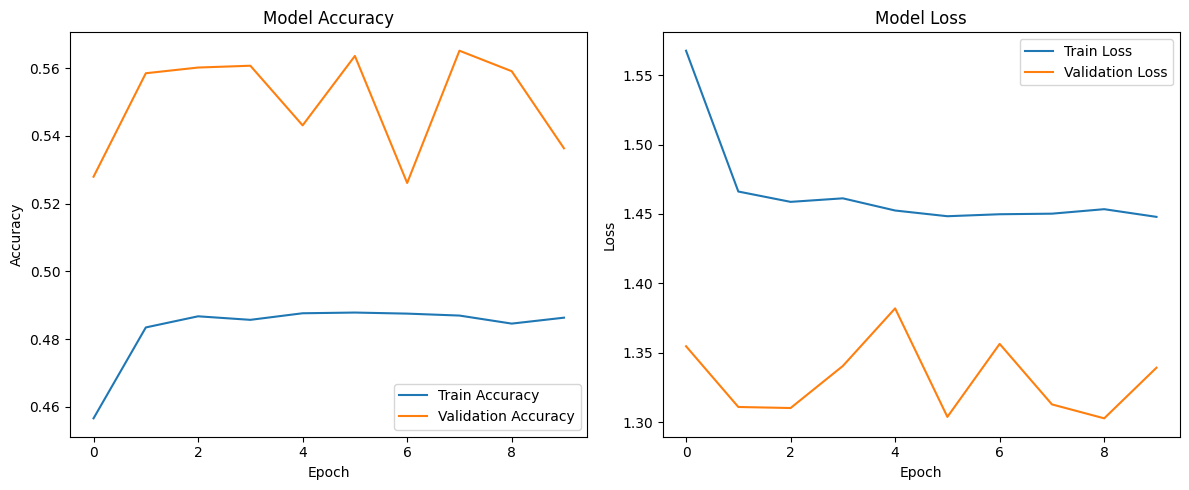

In [62]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparametric Tuning

In [63]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [66]:
# Defining the model with regularization
model2 = Sequential()

# Adding Bidirectional LSTM layer 
model2.add(Bidirectional(LSTM(64, return_sequences=True, 
                             kernel_regularizer=l2(0.001)), input_shape=(320, 1)))
model2.add(Dropout(0.3))  # Dropout with a rate of 30%

# Another LSTM layer with dropout
model2.add(Bidirectional(LSTM(64, return_sequences=True, 
                             kernel_regularizer=l2(0.001))))
model2.add(Dropout(0.3))

# TimeDistributed layer with attention for the output layer
model2.add(TimeDistributed(Dense(8, activation='softmax', kernel_regularizer=l2(0.001))))

# Compiling of the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# defining early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [67]:
# training the model with early stopping
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,  # 20 epocs
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/20
173/173 [==============================] - 128s 660ms/step - loss: 1.6977 - accuracy: 0.4494 - val_loss: 1.4948 - val_accuracy: 0.4913
Epoch 2/20
173/173 [==============================] - 104s 599ms/step - loss: 1.5126 - accuracy: 0.4830 - val_loss: 1.3151 - val_accuracy: 0.5614
Epoch 3/20
173/173 [==============================] - 106s 611ms/step - loss: 1.4795 - accuracy: 0.4912 - val_loss: 1.3270 - val_accuracy: 0.5582
Epoch 4/20
173/173 [==============================] - 107s 620ms/step - loss: 1.4660 - accuracy: 0.4936 - val_loss: 1.3272 - val_accuracy: 0.5560
Epoch 5/20
173/173 [==============================] - 107s 619ms/step - loss: 1.4665 - accuracy: 0.4905 - val_loss: 1.3411 - val_accuracy: 0.5427


In [77]:
# prediction on test data
y_pred2 = model2.predict(X_test)

17/17 [==============================] - 3s 183ms/step


In [87]:
# Evaluating the model and calculating the accuracy
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 56.14%


In [78]:
# Converting predictions and true labels to categorical classes

y_pred_classes2 = np.argmax(y_pred2, axis=-1)
y_test_classes2 = np.argmax(y_test, axis=-1)

In [79]:
# Flattening predictions and true labels 
y_pred_flat2 = y_pred_classes2.flatten()
y_test_flat2 = y_test_classes2.flatten()

In [83]:
# printing Classification Report
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat2, target_names=label_encoder.classes_, zero_division=0))

Classification Report:
              precision    recall  f1-score   support

           B       0.71      0.92      0.80     85401
           E       0.21      0.14      0.17     17263
           G       0.00      0.00      0.00      2925
           H       0.25      0.41      0.31     24674
           I       0.00      0.00      0.00        30
           L       0.53      0.06      0.11     16830
           S       0.00      0.00      0.00      7854
           T       0.00      0.00      0.00      9503

    accuracy                           0.56    164480
   macro avg       0.21      0.19      0.17    164480
weighted avg       0.48      0.56      0.49    164480



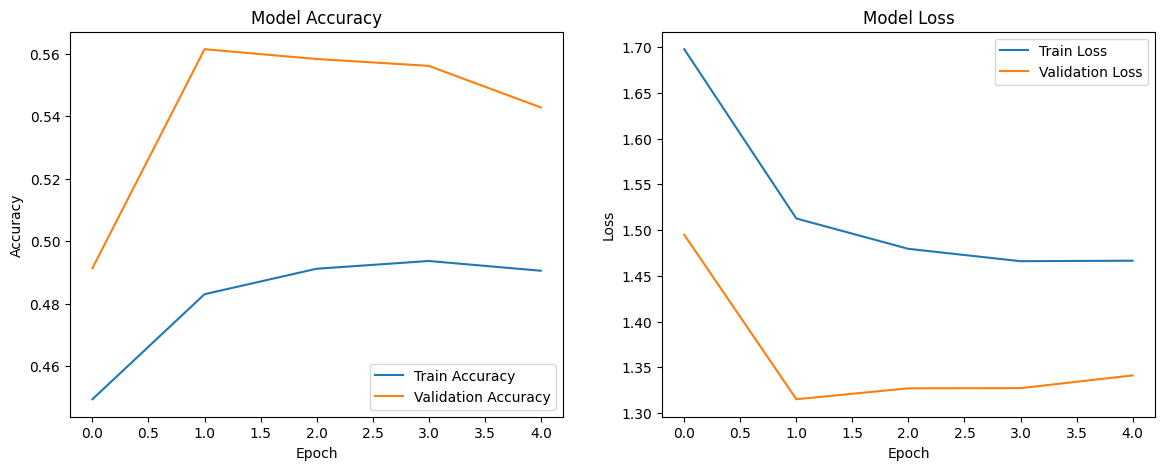

In [84]:
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')